# AGN spectral fittings and measuring line parameters with FANTASY

In [4]:
#Before starting, we call some of the standard python packages, such as matplotlib, pandas, numpy, etc.
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import numpy as np
import pandas as pd

import glob

In [5]:
# Below command import the above mentioned reading commands
from fantasy_agn.tools import read_sdss, read_text, read_gama_fits

# Below command import the necessary commands, which will be described later
from fantasy_agn.models import create_input_folder

from fantasy_agn.models import create_feii_model, create_model, create_tied_model, continuum, create_line, create_fixed_model

Select one type 1 AGN from SDSS

Object SDSS J210001.24-071136.3 (0637-52174-0259)

In [6]:
# This command reads the spectrum with the listed name, from the folder of this notebook or
# from the given path e.g.,'/path/to/files/spec*.txt'

s=read_sdss('spec-0268-51633-0235.fits')

Preparation of the spectra

In [7]:
# DeRedden() command corrects for the Galactic extinction, based on coordinates of the object provided in the fits,
# which will be automatically derived from dust map data from Schlegel, Finkbeiner, Davis (1998).
# If coordinates are not available you could manually insert them using simple commands s.ra=xxx.xxx, s.dec=xxx.xxx

# s.ra=29.519807539582 #example input of arbitrary rightascension
# s.dec=-0.872742349310271 #example input of arbitrary declination

s.DeRedden()

In [8]:
# CorRed() corrects for the cosmological redshift, based on redshift of the object provided in the fits.
# If coordinates are not available you could manually insert them using simple command s.z=x.xxx

# s.z=0.0804 #example input of arbitrary redshift

s.CorRed()

Host-galaxy subtraction

In [9]:
#s.restore() #command which restor to the original spectrum, before host-galaxy removal;
s.fit_host_sdss()

Host contribution is negliglable


In [10]:
s.restore() #command to restore the spectrum before host galaxy fitting and substraction
s.fit_host_sdss(mask_host=True, custom=False)

Host contribution is negliglable


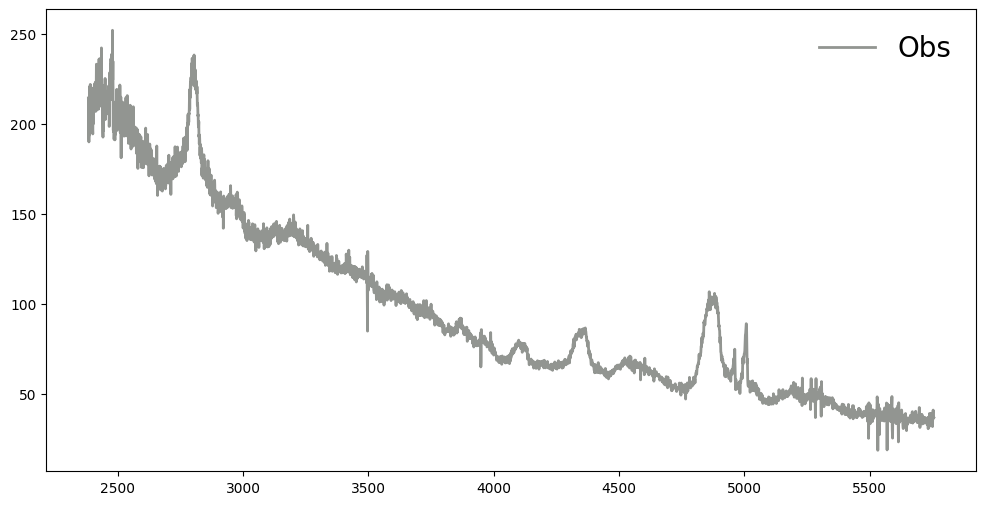

In [12]:
#Let's plot the spectrum for visual inspection.

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)

# It is obvious, e.g. based on the strong blue continuum and absence of absorption line, that the stellar contribution
# from the host galaxy can be negligible.

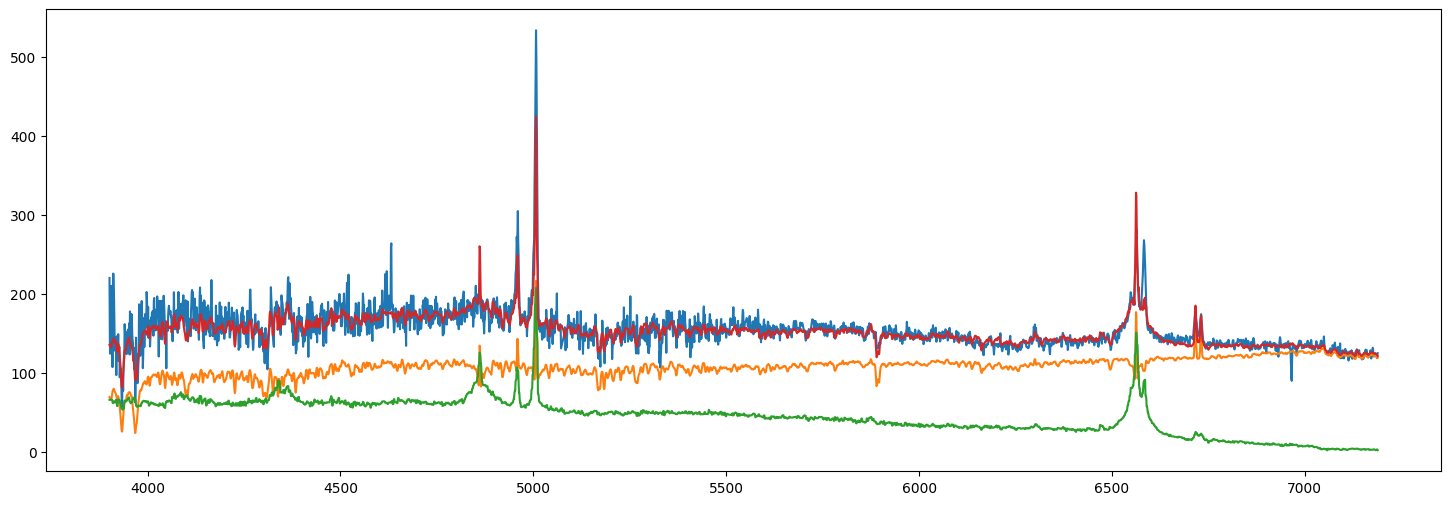

In [14]:
#Let us try another example spectrum, e.g. G09_Y1_GS1_080.fit. now from the GAMMA database, which is
# a low-luminosity host-dominated AGN at z=0.05488.

# TIP: The spectrum is very noisy in the blue part, therefore we crop the spectrum to 3900-8000A wavelength range,
# to avoid the noise, which is impossible to reproduce with the PCA, but leaving the strong stellar absorption
# features below 4000 A, i.e., Ca II resonance lines H(3968) and K(3933).

g=read_gama_fits('G09_Y1_GS1_080.fit')
g.DeRedden()
g.CorRed()
g.crop(3900,8000)
g.fit_host_sdss()


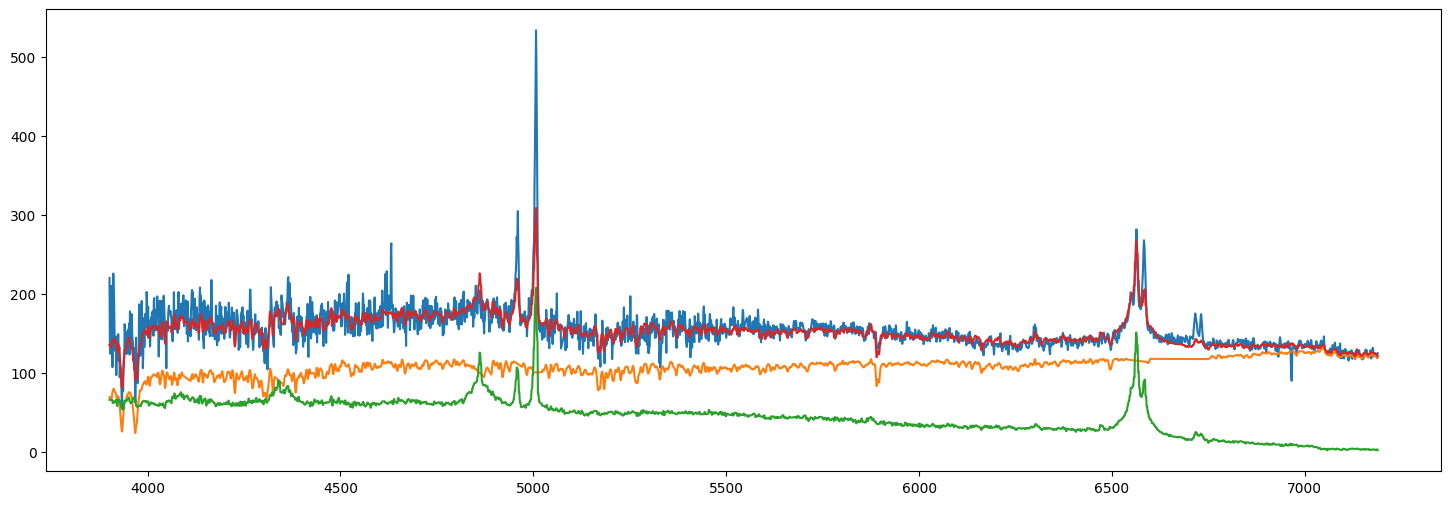

In [15]:
# Let us save the above host, and try fitting with the masked emission lines.
g.host_no_mask=g.host
g.restore()
g.fit_host_sdss(mask_host=True, custom=False)

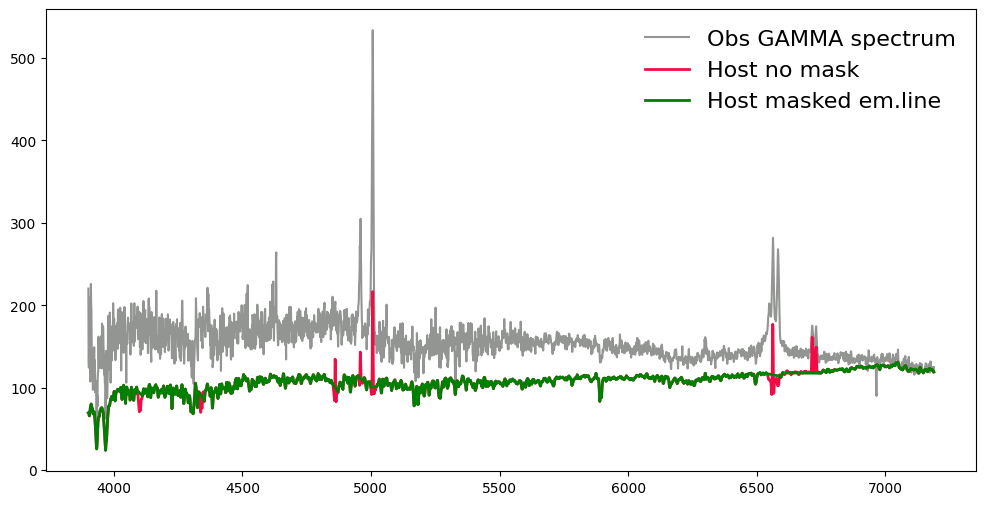

In [16]:
#Let's compare two host-fitting results.

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(g.wave, g.flux+g.host, color="#929591", label='Obs GAMMA spectrum' , lw=1.5)
plt.plot(g.wave, g.host_no_mask, color="#F10C45", label='Host no mask', lw=2)
plt.plot(g.wave, g.host, color="green", label='Host masked em.line', lw=2)
plt.legend(loc='upper right',  prop={'size': 16}, frameon=False)

Creation of the predefined lists of emission lines

In [17]:
create_input_folder(xmin=4000,xmax=8000, path_to_folder='liness/')
#create_input_folder(xmin=4000,xmax=8000, path_to_folder='lines/',overwrite=False)

Directory  liness/  Created 


In [18]:
# Crop function cuts the spectrum in a set wavelength range, e.g., if you want to fit just
# one emission line or a certain wavelength range

s.crop(4000, 8000)
print(s.wave) # simple examine of the wavelength range

[4000.6587 4001.5813 4002.502  ... 5753.5034 5754.8296 5756.1533]


Defining the fitting model

In [19]:
cont=continuum(s,min_refer=5690, refer=5700, max_refer=5710)
broad=create_fixed_model(['hydrogen.csv'], name='br')
he=create_fixed_model(['helium.csv'], name='he',fwhm=3000, min_fwhm=1000, max_fwhm=5000)
narrow=create_tied_model(name='OIII5007',files=['narrow_basic.csv','hydrogen.csv'],prefix='nr', fwhm=1000,min_offset=0, max_offset=300, min_fwhm=900, max_fwhm=1200,fix_oiii_ratio=True, position=5006.803341, included=True,min_amplitude=0.2)
fe=create_feii_model(name='feii', fwhm=1800, min_fwhm=1000, max_fwhm=2000, offset=0, min_offset=-3000, max_offset=3000)
#fe.amp_b4p.min=10 #An example how to force the amplitude of a selected FeII multiplet.

In [20]:
# Code fits simultaneously all features.
model = cont+broad+narrow+fe+he

Fittings

In [21]:
s.fit(model, ntrial=2)

stati 65415.901379213006
1 iter stat:  90.97609239193662
2 iter stat:  43.54521103784191


Plotting the results

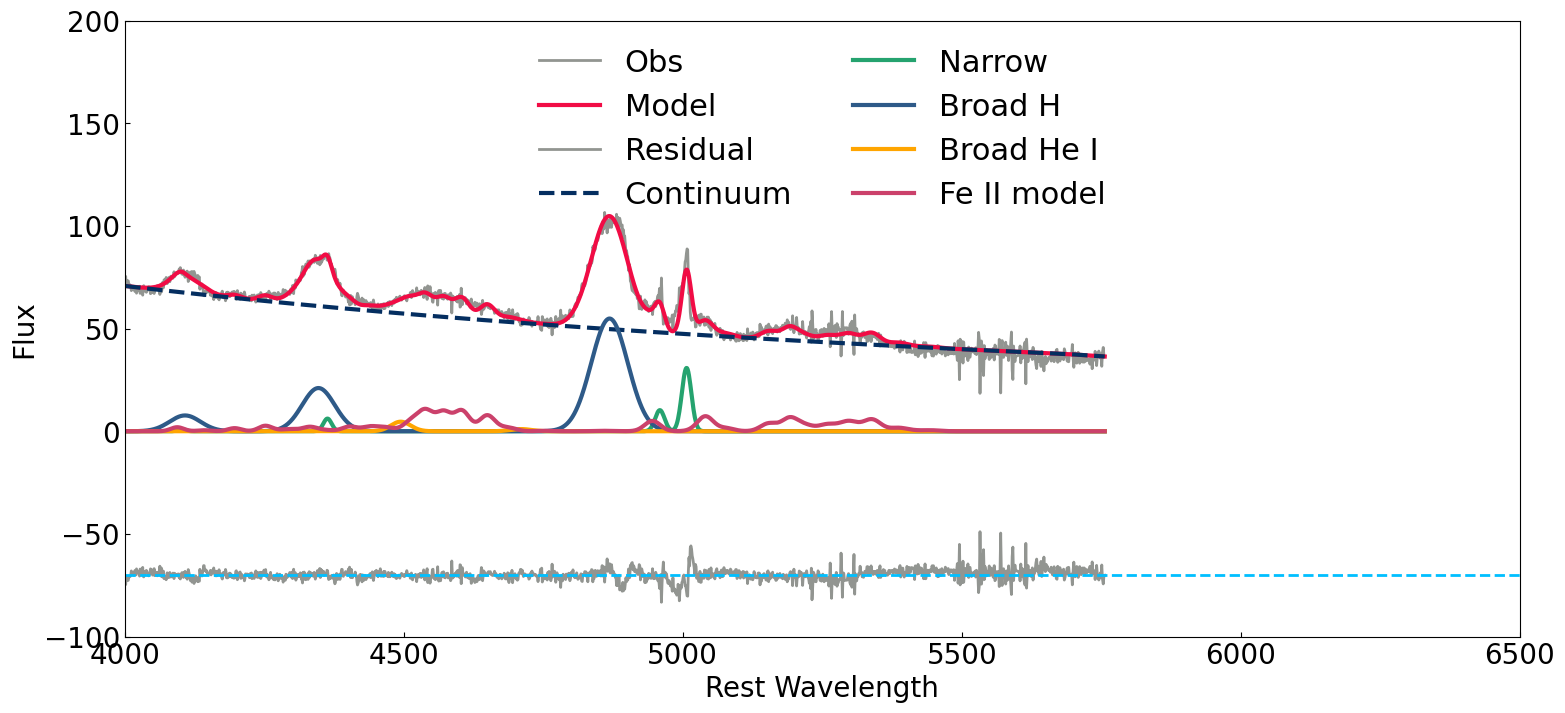

In [27]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,8))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.plot(s.wave, model(s.wave), color="#F10C45",label='Model',lw=3)
plt.plot(s.wave, model(s.wave)-s.flux-70, '-',color="#929591", label='Residual', lw=2)
plt.axhline(y=-70, color='deepskyblue', linestyle='--', lw=2)

plt.plot(s.wave, cont(s.wave),'--',color="#042E60",label='Continuum', lw=3)
plt.plot(s.wave, narrow(s.wave),label='Narrow',color="#25A36F",lw=3)
plt.plot(s.wave, broad(s.wave), label='Broad H', lw=3, color="#2E5A88")
plt.plot(s.wave, he(s.wave), label='Broad He I', lw=3, color="orange")
plt.plot(s.wave, fe(s.wave),'-',color="#CB416B",label='Fe II model', lw=3)

plt.xlabel('Rest Wavelength',fontsize=20)
plt.ylabel('Flux',fontsize=20)
plt.xlim(4000,5000)
plt.ylim(-100,200)
plt.tick_params(which='both', direction="in")
plt.yticks(fontsize=20)
plt.xticks(np.arange(4000, 7000, step=500),fontsize=20)
plt.legend(loc='upper center',  prop={'size': 22}, frameon=False, ncol=2)

plt.savefig('fantasy_fit.pdf')

Inspecting/saving the fitting results

In [28]:
model

<BinaryOpModel model instance '((((brokenpowerlaw + br) + (((((((((((((nr_OIII5007 + nr_OIII4958) + nr_NII6584) + nr_NIII6548) + nr_[OIII]_4363) + nr_[OI]_6300) + nr_[OI]_6363) + nr_[SII]_6716) + nr_[SII]_6730) + nr_[OII]_7330) + nr_Hd_4101) + nr_Hg_4340) + nr_Hb_4861) + nr_Ha_6562)) + feii) + he)'>

In [29]:
# To see the fitting results, one can use standard outputs from Sherpa package, such as:
# gres - to list all fitting results
# gres.parnames - to list all parameters
# save_json() - to save the results

print(s.gres.format())
s.save_json() #saving parameters

Method                = levmar
Statistic             = chi2
Initial fit statistic = 2983.51
Final fit statistic   = 2939.96 at function evaluation 1200
Data points           = 1581
Degrees of freedom    = 1529
Probability [Q-value] = 7.47936e-92
Reduced statistic     = 1.9228
Change in statistic   = 43.5452
   brokenpowerlaw.refer   5690.03      +/- 93.6977     
   brokenpowerlaw.ampl   37.5956      +/- 1.15958     
   brokenpowerlaw.index1   -1.79487     +/- 0.0147823   
   brokenpowerlaw.index2   -0.979735    +/- 2.39445     
   br.amp_Hd_4102   7.69806      +/- 0.40546     
   br.amp_Hg_4340   21.0433      +/- 0.653152    
   br.amp_Hb_4861   54.8856      +/- 0.568612    
   br.amp_Ha_6563   2.09848      +/- 0           
   br.offs_kms    453.741      +/- 13.4359     
   br.fwhm        4748.92      +/- 38.4366     
   nr_OIII5007.ampl   30.8577      +/- 0.664617    
   nr_OIII5007.offs_kms   0.024785     +/- 10.8682     
   nr_OIII5007.fwhm   1197.09      +/- 27.2215     
   nr_NII6

Simple analysis

In [30]:
# Integrate total FeII model,
flux_feII=np.sum(fe(s.wave))
print("FeII total flux=",flux_feII)

# Mask the wavelength range of interess (e.g. Ha line) and integrate broad component.
x=s.wave
mask_ha=(x>6300)&(x<6700)
Ha_broad=np.sum(broad(s.wave)[mask_ha])
print("Ha_broad=",Ha_broad)

FeII total flux= 3321.203
Ha_broad= 0.0
